In [1]:
%load_ext autoreload
%autoreload 2

In [46]:
import re
import math
import pandas as pd
from gplearn.tests.test_genetic import *
from gplearn._program import _Program
from gplearn.genetic import _all_func_dictionary, _fitness_map, _extra_fitness_map
from gplearn.extra_fitness_2 import *
from gplearn.extra_fitness_2 import _bad_fitness_val, _annual_bar_8h, _fee_rate
import matplotlib.pyplot as plt
import time

## Load data

In [3]:
df = pd.read_parquet('/home/pennymax/proj/MFM/CrossSection/v1_basic/basic_8h_2/fct_proc.parquet')
start_date = '2020-09-01 00:00:00+00:00'
end_date = '2024-01-01 00:00:00+00:00'
df = df.query('@start_date <= time < @end_date')
display(df)
display(df.index.get_level_values(0).unique())

Open      High       Low    Close  \
time                      symbol                                            
2020-09-01 00:00:00+00:00 ADAUSDT    0.12264   0.12590   0.11915   0.1255   
                          ALGOUSDT   0.50240   0.55440   0.49100   0.5345   
                          ATOMUSDT   7.20800   7.65700   6.98800   7.5770   
                          BANDUSDT  13.02300  14.57000  12.62930  14.5275   
                          BATUSDT    0.34860   0.35300   0.33950   0.3504   
...                                      ...       ...       ...      ...   
2023-12-31 16:00:00+00:00 YGGUSDT    0.42610   0.44570   0.40710   0.4261   
                          ZECUSDT   28.46000  28.57000  25.47000  26.9300   
                          ZENUSDT    9.47300   9.60900   8.63000   9.0610   
                          ZILUSDT    0.02533   0.02572   0.02400   0.0248   
                          ZRXUSDT    0.36810   0.38640   0.35870   0.3720   

                                          Volume        QuoVol   TrdCnt  \
time                      symbol                                          
2020-09-01 00:00:00+00:00 ADAUSDT   1.859759e+08  2.291442e+07  62712.0   
                          ALGOUSDT  3.380250e+07  1.795758e+07  55267.0   
                          ATOMUSDT  1.725656e+06  1.265856e+07  44745.0   
                          BANDUSDT  1.826682e+06  2.503081e+07  65798.0   
                          BATUSDT   1.470791e+07  5.097133e+06  28028.0   
...                                          ...           ...      ...   
2023-12-31 16:00:00+00:00 YGGUSDT   2.090920e+07  8.998258e+06  73970.0   
                          ZECUSDT   6.489027e+05  1.773391e+07  82423.0   
                          ZENUSDT   1.193518e+06  1.097834e+07  93218.0   
                          ZILUSDT   3.197006e+08  8.006506e+06  45641.0   
                          ZRXUSDT   2.997073e+07  1.121517e+07  72115.0   

                                     TakerBuyVol  TakerBuyQuoVol  \
time                      symbol                                   
2020-09-01 00:00:00+00:00 ADAUSDT   8.661606e+07    1.068731e+07   
                          ALGOUSDT  1.593180e+07    8.483083e+06   
                          ATOMUSDT  8.138771e+05    5.976147e+06   
                          BANDUSDT  9.456576e+05    1.296762e+07   
                          BATUSDT   7.174132e+06    2.488173e+06   
...                                          ...             ...   
2023-12-31 16:00:00+00:00 YGGUSDT   9.465695e+06    4.081564e+06   
                          ZECUSDT   2.529282e+05    6.929311e+06   
                          ZENUSDT   4.803335e+05    4.426438e+06   
                          ZILUSDT   1.390138e+08    3.484169e+06   
                          ZRXUSDT   1.442174e+07    5.393244e+06   

                                    funding_rate  ...  avgtrdquo5  vwap_bias1  \
time                      symbol                  ...                           
2020-09-01 00:00:00+00:00 ADAUSDT       0.000688  ...  363.500082    0.981767   
                          ALGOUSDT      0.000749  ...  277.246167    0.993920   
                          ATOMUSDT      0.001045  ...  254.119889    0.968128   
                          BANDUSDT     -0.000760  ...  362.446953    0.943237   
                          BATUSDT       0.000100  ...  189.741901    0.989034   
...                                          ...  ...         ...         ...   
2023-12-31 16:00:00+00:00 YGGUSDT       0.000630  ...  112.184503    1.009973   
                          ZECUSDT       0.000511  ...  183.972953    1.014819   
                          ZENUSDT       0.000394  ...  101.876953    1.015153   
                          ZILUSDT       0.000469  ...  157.213519    1.009829   
                          ZRXUSDT       0.000489  ...  139.593260    1.005925   

                                    vwap_bias3  vwap_bias5  trd_vwap_bias1  \
time                      symbol             

DatetimeIndex(['2020-09-01 00:00:00+00:00', '2020-09-01 08:00:00+00:00',
               '2020-09-01 16:00:00+00:00', '2020-09-02 00:00:00+00:00',
               '2020-09-02 08:00:00+00:00', '2020-09-02 16:00:00+00:00',
               '2020-09-03 00:00:00+00:00', '2020-09-03 08:00:00+00:00',
               '2020-09-03 16:00:00+00:00', '2020-09-04 00:00:00+00:00',
               ...
               '2023-12-28 16:00:00+00:00', '2023-12-29 00:00:00+00:00',
               '2023-12-29 08:00:00+00:00', '2023-12-29 16:00:00+00:00',
               '2023-12-30 00:00:00+00:00', '2023-12-30 08:00:00+00:00',
               '2023-12-30 16:00:00+00:00', '2023-12-31 00:00:00+00:00',
               '2023-12-31 08:00:00+00:00', '2023-12-31 16:00:00+00:00'],
              dtype='datetime64[us, UTC]', name='time', length=3651, freq=None)

## Calc y_pred

In [4]:
def _get_X_y(df):
    df = df.sort_index()
    dfX = df.drop(columns=[col for col in df.columns if col.startswith('fwdret')])
    feature_names = list(dfX.columns)
    dfX = dfX.unstack().sort_index()
    X = dfX.values.reshape(len(dfX), len(feature_names), -1)

    y = df[['fwdret1']].unstack().sort_index().to_numpy()
    return X, y, feature_names

def _convert_expression_to_gp_program(expression: str, function_set: dict, feature_names: list) -> _Program:
    ## convert expression to list function obj and feature index
    tokens = re.findall(r'[\w.]+|\(|\)|,', expression)
    tokens = [t for t in tokens if t not in ['(', ')', ',']]
    # print(tokens)
    program = []
    for token in tokens:
        if token in function_set:
            program.append(function_set[token])
        elif token in feature_names:
            program.append(feature_names.index(token))
        elif token.isdigit():
            program.append(int(token))
        elif token.replace('.', '', 1).isdigit():
            program.append(float(token))
        else:
            print(f'  !! unknown token found! {token}')
            return None
    # print(program)

    ## get arity dict
    arities = {}
    for function in function_set.values():
        arity = function.arity
        arities[arity] = arities.get(arity, [])
        arities[arity].append(function)

    ## construct _Program obj
    params = {
            'function_set': function_set,
            'arities': arities,
            'n_features': len(feature_names),
            'feature_names': feature_names,
            'init_depth': (2, 6),
            ## must inputs
            'init_method': 'half and half',
            'const_range': (-1.0, 1.0),
            'metric': 'mean absolute error',
            'p_point_replace': 0.05,
            'parsimony_coefficient': 0.1,
            'random_state': check_random_state(None),
            }
    gp = _Program(program=program, **params)
    return gp

In [8]:
X, y, feature_names = _get_X_y(df)
w = np.ones(X.shape[0])
print(X.shape, y.shape, w.shape, len(feature_names))

(3651, 52, 257) (3651, 257) (3651,) 52


In [6]:
feature_names

['Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'QuoVol',
 'TrdCnt',
 'TakerBuyVol',
 'TakerBuyQuoVol',
 'funding_rate',
 'premIdx_open',
 'premIdx_high',
 'premIdx_low',
 'premIdx_close',
 'spot_Open',
 'spot_High',
 'spot_Low',
 'spot_Close',
 'spot_Vol',
 'spot_QuoVol',
 'spot_TrdCnt',
 'spot_TakerBuyVol',
 'spot_TakerBuyQuoVol',
 'oi',
 'oiquo',
 'topPosLSCntRt',
 'topPosLSRt',
 'posLSRt',
 'bckret1',
 'bckret3',
 'bckret5',
 'netbuyquo1',
 'netbuyquo3',
 'netbuyquo5',
 'spot_netbuyquo1',
 'spot_netbuyquo3',
 'spot_netbuyquo5',
 'spotum_quo_rt1',
 'spotum_quo_rt3',
 'spotum_quo_rt5',
 'avgtrdquo1',
 'avgtrdquo3',
 'avgtrdquo5',
 'vwap_bias1',
 'vwap_bias3',
 'vwap_bias5',
 'trd_vwap_bias1',
 'trd_vwap_bias3',
 'trd_vwap_bias5',
 'takerbuy_ratio1',
 'takerbuy_ratio3',
 'takerbuy_ratio5']

In [23]:
exp = 'netbuyquo3'
# exp = 'ta_APO_12_26(ts_autocorr_60_1(signed_log(ts_autocorr_20_10(trd_vwap_bias5))))'
exp = 'tszs_120_add(ta_BBANDSl_5_2_2(spot_Open), ta_TEMA_5(netbuyquo3))'

print(f'ori expression: {exp}')
gp = _convert_expression_to_gp_program(exp, _all_func_dictionary, feature_names)
print(f'_Program print: {gp}')

y_pred = gp.execute_3D(X)
display(pd.DataFrame(y_pred))
display(pd.DataFrame(y_pred).describe())

# %timeit gp.execute_3D(X)

ori expression: tszs_120_add(ta_BBANDSl_5_2_2(spot_Open), ta_TEMA_5(netbuyquo3))
_Program print: tszs_120_add(ta_BBANDSl_5_2_2(spot_Open), ta_TEMA_5(netbuyquo3))


,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3646,1.880714,0.992859,0.660812,0.984839,1.331012,1.457597,2.812890,-0.839878,1.404510,-1.959581,...,1.493282,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3647,2.296864,0.483846,0.965382,2.170691,1.503889,1.816303,2.784588,-0.009157,2.287912,-1.751944,...,1.511655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3648,2.265989,0.314221,1.353286,2.357885,1.467190,2.459558,2.697312,0.670914,2.523815,-0.972862,...,1.428466,NaN,-1.130736,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3649,1.920781,1.000543,1.557969,-1.080148,0.808788,2.162347,2.743431,0.285836,2.812488,-0.700032,...,1.049884,NaN,-1.160027,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
count,3580.000000,3580.000000,3580.000000,3580.000000,3580.000000,3580.000000,3580.000000,3580.000000,3580.000000,3580.000000,...,12.000000,0.0,3.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,-0.018631,-0.063787,-0.003487,-0.059860,-0.008455,-0.084049,0.133730,0.180671,-0.054832,-0.040582,...,1.025809,NaN,-1.123363,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1.497123,1.482013,1.510352,1.459062,1.470101,1.511239,1.638746,1.592989,1.613270,1.534379,...,0.475799,NaN,0.040853,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,-8.805001,-7.743292,-7.717376,-7.294305,-8.511954,-6.631278,-10.873983,-9.845308,-7.346923,-8.640932,...,0.042547,NaN,-1.160027,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,-0.862739,-0.905625,-0.911848,-0.942447,-0.868991,-0.965296,-0.725246,-0.727276,-0.998510,-0.908879,...,0.852467,NaN,-1.145381,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,0.008621,-0.028850,-0.034881,-0.107281,0.012818,-0.085040,0.149096,0.240026,-0.126538,-0.009567,...,1.128005,NaN,-1.130736,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,0.952839,0.867128,0.933384,0.828844,0.949202,0.831010,1.173287,1.204971,0.858560,0.920958,...,1.387362,NaN,-1.105031,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,6.096780,6.401918,5.637095,7.976216,6.071763,8.420401,5.258487,6.966076,8.183259,6.441094,...,1.511655,NaN,-1.079326,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Fitness perf imporovment

In [18]:
from contextlib import contextmanager

@contextmanager
def timer(label):
    start = time.perf_counter()
    try:
        yield
    finally:
        end = time.perf_counter()
        # print(f"== {label}: {end - start:.4f} seconds ==")


### old

In [21]:
def quantile_returns_and_groups_old(y, y_pred, quantile):
    with timer('  prepare'):
        fwdrets = pd.DataFrame(y)
        factor = pd.DataFrame(y_pred)

        ## use y (return) to mask y_pred to set 0 on all invaid cells to nan
        factor = factor.mask(fwdrets.isna())
        # display(factor)
    
    # with timer('  quantile'):
        ret_qtl = []
        for _, grp in factor.stack().dropna().groupby(level=0, group_keys=True):
            ranks = grp.rank(method='first')   # method first means assign different ranks on identical values
            bins = np.linspace(1, ranks.max(), quantile + 1)
            qtl = np.searchsorted(bins, ranks, side='left')
            qtl[qtl==0] = 1
            ret_qtl.append(pd.Series(qtl, index=ranks.index))
        if ret_qtl:
            ## time x group_of_symbol (symbols number)
            stacked_factor_quantiles = pd.concat(ret_qtl)
        else:
            return pd.DataFrame(), pd.DataFrame()

    # with timer('  format data'):
        stacked_rets = fwdrets.stack()
        ## time x group_mean_return (group number)
        grouped_returns = (
            stacked_rets
            .groupby([stacked_rets.index.get_level_values(0), stacked_factor_quantiles])
            .mean()
            .unstack()
            )
    return grouped_returns, stacked_factor_quantiles.unstack()

def quantile_longshort_returns_old(y, y_pred, w, quantile, fee_rate) -> pd.Series:

    with timer('check'):
        if y.shape[0] != y_pred.shape[0]:
            return pd.Series()
        y_pred = y_pred[w.astype(bool)]
        y = y[w.astype(bool)]
        if is_bad_data(y, y_pred):
            return pd.Series()
    
    # with timer('quantile_returns_and_groups_new'):
        grouped_returns, factor_quantiles = quantile_returns_and_groups_old(y, y_pred, quantile)
        if grouped_returns.empty or factor_quantiles.empty or quantile not in grouped_returns.columns or 1 not in grouped_returns.columns:
            return pd.Series()
        longshort_rets = (grouped_returns[quantile] - grouped_returns[1]) / 2 ## not abs here as we need to calc camp and sub fee

    # with timer('fee'):
        if fee_rate and fee_rate > 0:
            longshort_fee = calc_longshort_fee(factor_quantiles, quantile, fee_rate)
            longshort_rets = longshort_rets - longshort_fee
            # print(np.where(np.isinf(longshort_rets)))
    
    return longshort_rets

In [22]:
grouped_returns, factor_quantiles = quantile_returns_and_groups_old(y, y_pred, 35)
display(grouped_returns)
display(factor_quantiles)
dfqtlold = pd.DataFrame(factor_quantiles)
dfretold = pd.DataFrame(grouped_returns)
# dfqtl[dfqtl==35].stack().dropna().to_frame().reset_index().drop(columns=[0]).groupby('level_0').agg(lambda g: g.tolist())

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0
71,-0.004647,0.000803,-0.010941,-0.018341,-0.017563,0.010685,-0.007086,0.001720,0.065004,-0.019838,...,0.017490,-0.001181,-0.029131,-0.001812,-0.016323,-0.007907,-0.006676,0.046196,-0.000765,0.016305
72,0.062376,0.057827,0.005150,0.028271,0.004855,0.020071,0.011746,0.089768,0.001866,0.034116,...,0.028219,0.000202,0.010852,0.014949,-0.002894,0.032482,0.058751,-0.003902,-0.051142,0.016389
73,0.004422,0.002604,-0.008291,0.037159,0.080996,0.012259,-0.018882,0.017490,0.019105,0.047791,...,0.031880,0.022422,0.007804,0.060164,0.008872,-0.001085,0.033970,0.004013,-0.006219,-0.012761
74,0.004798,0.011733,0.028668,0.007810,0.000000,0.031289,0.007512,-0.025402,0.011124,0.015084,...,0.020807,-0.013032,-0.021450,0.001295,0.008400,0.004174,0.001674,-0.019822,-0.018986,0.010648
75,-0.013379,0.050816,0.030999,-0.017760,0.002899,0.049817,0.000414,0.008647,-0.008891,0.013606,...,0.001970,0.004276,0.008143,0.012483,0.025706,-0.041374,-0.021268,0.001611,0.052490,-0.003878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3646,-0.008037,-0.004133,-0.007813,-0.004549,-0.007514,-0.008456,-0.006698,-0.013481,-0.007414,-0.005459,...,-0.015873,0.004147,0.002969,-0.005325,-0.012281,0.001449,-0.016491,-0.009450,0.014363,-0.002413
3647,0.004550,-0.003468,0.016283,0.020155,0.007741,0.018182,0.011003,0.018324,0.013025,0.019781,...,0.007608,0.029100,0.019360,0.040619,0.003104,0.007388,0.014655,0.016698,0.001859,0.006955
3648,-0.000811,-0.002608,-0.002381,-0.004451,-0.009958,-0.008406,0.001199,-0.005718,-0.001899,-0.007847,...,-0.013425,-0.018403,-0.003082,-0.007409,-0.009182,0.006003,0.001838,-0.001777,0.003767,0.041434
3649,0.004961,-0.023020,-0.025836,-0.016322,-0.011492,-0.031767,-0.010294,-0.009039,-0.021273,-0.016563,...,-0.023368,-0.017053,-0.016148,-0.012618,0.003229,-0.029301,-0.019371,-0.012621,-0.029393,-0.053230


,0,1,2,3,4,5,6,7,8,9,...,238,239,241,242,243,244,245,246,247,249
71,9.0,11.0,13.0,14.0,7.0,30.0,27.0,35.0,4.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,12.0,28.0,19.0,8.0,6.0,29.0,30.0,33.0,5.0,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73,28.0,26.0,29.0,7.0,8.0,22.0,30.0,33.0,9.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74,33.0,26.0,34.0,9.0,16.0,22.0,31.0,32.0,10.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,35.0,8.0,32.0,5.0,24.0,16.0,30.0,33.0,12.0,24.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3646,26.0,13.0,9.0,13.0,18.0,21.0,35.0,2.0,20.0,1.0,...,1.0,4.0,28.0,25.0,9.0,3.0,21.0,15.0,21.0,NaN
3647,29.0,5.0,10.0,27.0,17.0,22.0,33.0,3.0,29.0,1.0,...,1.0,3.0,27.0,24.0,6.0,3.0,16.0,13.0,18.0,NaN
3648,26.0,4.0,13.0,27.0,15.0,28.0,32.0,6.0,30.0,1.0,...,1.0,5.0,25.0,27.0,10.0,7.0,11.0,8.0,15.0,1.0
3649,23.0,9.0,16.0,1.0,7.0,27.0,33.0,5.0,34.0,2.0,...,1.0,5.0,28.0,29.0,5.0,12.0,8.0,4.0,10.0,1.0


In [24]:
longshort_rets = quantile_longshort_returns_old(y, y_pred, w, quantile=35, fee_rate=_fee_rate)
display(longshort_rets)
with timer('sharpe'):
    sharpe = sharpe_fine(longshort_rets, comp=True, annual_bars=_annual_bar_8h)
display(sharpe)

71      0.010476
72     -0.022993
73     -0.008592
74      0.002925
75      0.004750
          ...   
3646    0.002812
3647    0.001202
3648    0.021122
3649   -0.029095
3650    0.017936
Length: 3580, dtype: float64

7.622191454777886

### New

In [383]:
def quantile_returns_and_groups_new_1(y, y_pred, quantile):
    mask = np.isnan(y)
    y_pred_masked = np.where(mask, np.nan, y_pred)

    # 初始化分位数数组
    # quantiles = np.zeros_like(y_pred_masked)
    quantiles = np.full(y_pred_masked.shape, np.nan)

    # 计算每个资产的排名和分位数，与 Pandas 版本相似
    for i in range(y_pred_masked.shape[0]):
        cs = y_pred_masked[i, :]
        valid_mask = ~np.isnan(cs)
        if np.all(np.isnan(cs)):
            continue
        ranks = np.argsort(np.argsort(cs[valid_mask])) + 1
        bins = np.linspace(1, ranks.max(), quantile + 1)
        quantiles_values = np.searchsorted(bins, ranks, side='left')
        quantiles[i, valid_mask] = np.maximum(quantiles_values, 1)
    if np.all(np.isnan(quantiles)):
        return None, None

    # 计算分组平均回报
    dfy = pd.DataFrame(y)
    stacked_rets = dfy.stack()
    ## time x group_mean_return (group number)
    grouped_returns = (
        stacked_rets
        .groupby([stacked_rets.index.get_level_values(0), pd.DataFrame(quantiles).stack()])
        .mean()
        .unstack()
        .reindex(dfy.index)  ## to keep exact same shape with y
        .to_numpy()
        )

    # print(grouped_returns.shape, quantiles.shape)
    # assert(grouped_returns.shape[0] == quantiles.shape[0])

    return grouped_returns, quantiles

def is_bad_data_new(y, y_pred, max_full_nan_cs_rate=0.3, min_valid_rate=0.7):
    # 检查是否有过多的完全是 NaN 的行（cross-sections）
    all_na_cs_mask = np.all(np.isnan(y_pred), axis=1)
    too_many_invalid_full_nan_cs = np.mean(all_na_cs_mask) > max_full_nan_cs_rate
    
    # 计算 y_pred 和 y 中非 NaN 值的数量
    valid_y_pred = np.sum(~np.isnan(y_pred), axis=1)
    valid_y = np.sum(~np.isnan(y), axis=1)

    # 避免除以零的情况
    valid_mask = valid_y != 0
    valid_rates = valid_y_pred[valid_mask] / valid_y[valid_mask]

    # 计算平均有效率，并检查是否过低
    too_low_mean_valid_rate = np.mean(valid_rates) < min_valid_rate if valid_rates.size > 0 else True

    return too_many_invalid_full_nan_cs or too_low_mean_valid_rate

def turnover_rates_new(arr):
    # 将 NaN 转换为 False，非 NaN 转换为 True
    # valid_data = ~np.isnan(arr)
    # 计算每一行的变化（True 到 False 或 False 到 True）
    changes = np.diff(valid_data, axis=0)
    # print(valid_data.shape, changes.shape)
    per_bar_changes = np.sum(np.abs(changes), axis=1) / 2
    # 在 per_bar_changes 的开头添加一个 0 或 np.nan 以匹配长度
    per_bar_changes = np.insert(per_bar_changes, 0, 0)
    # 计算每一行的非 NaN 计数
    per_bar_count = np.sum(valid_data, axis=1).astype(float)
    # 防止除以零
    per_bar_count[per_bar_count == 0] = np.nan
    # 计算转换率
    rates = per_bar_changes / np.roll(per_bar_count, 1)
    # 处理无穷值
    rates[np.isinf(rates)] = 0
    return rates

def calc_longshort_fee_new(factor_quantiles, quantile, fee_rate):
    # 计算长仓费率
    long_positions = factor_quantiles == quantile
    long_rates = turnover_rates_new(long_positions)
    
    # 计算短仓费率
    short_positions = factor_quantiles == 1
    short_rates = turnover_rates_new(short_positions)
    
    # 计算长短仓的平均费率
    longshort_rates = (long_rates + short_rates) / 2
    # 计算费用
    longshort_fee = longshort_rates * fee_rate
    return longshort_fee

def quantile_longshort_returns_new(y, y_pred, w, quantile, fee_rate) -> pd.Series:

    with timer('check'):
        if y.shape[0] != y_pred.shape[0]:
            return pd.Series()
        y_pred = y_pred[w.astype(bool)]
        y = y[w.astype(bool)]
        if is_bad_data_new(y, y_pred):
            return pd.Series()
    
    # with timer('quantile_returns_and_groups_new'):
        grouped_returns, factor_quantiles = quantile_returns_and_groups_new_1(y, y_pred, quantile)
        if grouped_returns is None or factor_quantiles is None or \
            np.all(np.isnan(grouped_returns)) or np.all(np.isnan(factor_quantiles)) or \
            grouped_returns.shape[1] != quantile:
            return pd.Series()
        longshort_rets = (grouped_returns[:, 34] - grouped_returns[:, 0]) / 2 ## not abs here as we need to calc camp and sub fee
        # print('grouped_returns:', grouped_returns.shape)
        # print('factor_quantiles:', factor_quantiles.shape)

    # with timer('fee'):
        if fee_rate and fee_rate > 0:
            longshort_fee = calc_longshort_fee_new(factor_quantiles, quantile, fee_rate)
            longshort_rets = longshort_rets - longshort_fee
            # print(np.where(np.isinf(longshort_rets)))
    
    return longshort_rets

In [384]:
print(y.shape, y_pred.shape)
grouped_returns, factor_quantiles = quantile_returns_and_groups_new_1(y, y_pred, 35)
display(pd.DataFrame(grouped_returns))
display(pd.DataFrame(factor_quantiles))

dfqtl_new_1 = pd.DataFrame(factor_quantiles)
# dfqtl[dfqtl==35].stack().dropna().to_frame().reset_index().drop(columns=[0]).groupby('level_0').agg(lambda g: g.tolist())
print(dfqtl_new_1.dropna(axis=0, how='all').equals(dfqtlold.dropna(axis=0, how='all')))

dfretnew_1 = pd.DataFrame(grouped_returns)
dfretnew_1.columns = dfretold.columns
print(dfretnew_1.dropna(axis=0, how='all').round(3).equals(dfretold.dropna(axis=0, how='all').round(3)))

(3651, 257) (3651, 257)


,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,-0.018556,0.039893,-0.059552,-0.076669,-0.024791,-0.014151,0.007921,-0.029004,0.008817,-0.021434,...,-0.030096,-0.043194,-0.038564,-0.053333,0.002487,-0.006742,-0.033262,0.015674,0.008947,-0.006675
1,0.006107,-0.014280,-0.023902,-0.038963,-0.000560,-0.013518,0.026172,0.050318,0.022895,0.031699,...,-0.010179,-0.008506,0.026232,-0.014671,0.004962,0.000309,0.021767,0.004764,0.005505,0.076278
2,-0.018842,-0.017031,-0.019791,0.013579,-0.014181,-0.011506,-0.026636,0.010341,-0.024228,-0.037391,...,0.038317,-0.024460,-0.042069,-0.016475,-0.023903,-0.016348,-0.040611,-0.032302,-0.015361,-0.057759
3,-0.054019,-0.057345,-0.062898,-0.076211,-0.067399,-0.071893,-0.115539,-0.075832,-0.014673,-0.069473,...,-0.064330,-0.059720,-0.048488,-0.073571,-0.034783,-0.052883,-0.057714,-0.080339,-0.037316,-0.091667
4,0.010494,-0.000810,-0.014295,0.008591,0.018075,0.020596,0.006759,0.020124,0.004504,0.031188,...,0.027296,0.027448,0.025064,0.020483,0.042256,0.017326,0.020253,0.019948,0.039065,0.038010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3646,-0.014551,-0.010437,-0.012426,-0.010951,-0.001042,-0.015729,-0.011640,-0.013908,-0.001041,-0.004725,...,-0.010340,-0.005129,-0.008063,-0.003196,-0.009886,0.006447,-0.002411,-0.010170,-0.004410,0.003931
3647,0.019940,0.014024,0.017810,0.015221,0.019741,0.012993,0.005681,0.001826,0.018652,0.004603,...,0.011258,0.015267,0.013354,0.006391,0.039227,0.035278,0.018964,0.022424,0.003214,0.028450
3648,-0.010056,0.012873,0.006803,-0.012507,-0.002178,-0.008710,-0.003969,0.004736,0.005633,-0.000739,...,-0.011277,-0.008125,-0.001056,-0.010007,-0.018445,-0.010156,0.012870,-0.005291,-0.001461,0.028381
3649,-0.010274,-0.023217,-0.046726,-0.008868,-0.020104,-0.038947,-0.021011,-0.014167,-0.008494,-0.003234,...,-0.012245,-0.027227,-0.000992,0.018720,-0.014475,-0.014723,-0.004002,-0.014694,-0.016783,-0.061086


,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,8.0,14.0,19.0,21.0,22.0,11.0,9.0,1.0,35.0,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9.0,15.0,18.0,21.0,23.0,7.0,8.0,1.0,35.0,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9.0,15.0,17.0,24.0,22.0,16.0,8.0,1.0,35.0,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10.0,15.0,17.0,23.0,27.0,8.0,9.0,1.0,35.0,32.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11.0,13.0,21.0,23.0,24.0,4.0,9.0,1.0,35.0,31.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3646,3.0,11.0,4.0,22.0,30.0,4.0,2.0,1.0,9.0,16.0,...,17.0,6.0,16.0,2.0,7.0,22.0,33.0,13.0,15.0,3.0
3647,3.0,10.0,4.0,16.0,32.0,4.0,5.0,1.0,9.0,16.0,...,14.0,7.0,15.0,2.0,6.0,19.0,33.0,16.0,12.0,4.0
3648,4.0,9.0,5.0,19.0,31.0,3.0,2.0,1.0,9.0,13.0,...,14.0,8.0,18.0,5.0,7.0,18.0,34.0,10.0,11.0,5.0
3649,3.0,10.0,4.0,11.0,31.0,3.0,2.0,1.0,12.0,13.0,...,12.0,7.0,15.0,6.0,7.0,17.0,35.0,6.0,11.0,3.0


True
True


In [385]:
longshort_rets_new = quantile_longshort_returns_new(y, y_pred, w, quantile=35, fee_rate=_fee_rate)
display(pd.Series(longshort_rets_new))
pd.Series(longshort_rets_new).dropna().equals(longshort_rets.dropna())
sharpe_new = sharpe_fine(pd.Series(longshort_rets_new).dropna(), comp=True, annual_bars=_annual_bar_8h)
display(sharpe_new)

0       0.005940
1       0.035085
2      -0.019459
3      -0.018824
4       0.013758
          ...   
3646    0.009241
3647    0.004255
3648    0.019218
3649   -0.025406
3650   -0.000408
Length: 3651, dtype: float64

2.86565735484918

In [62]:
# processing program inv(oiquo)                                                                                                                                                                                                                                 
# [time cost] total: 0.1043 execute_3d: 0.0022 metric: 0.1021 metric_val: -0.2797 

# exp = 'inv(oiquo)'
# exp = 'netbuyquo3'
# exp = 'ts_min_20(tszs_60_min(spot_Low, takerbuy_ratio5))'
exp = 'tszs_120_add(ta_BBANDSl_5_2_2(spot_Open), ta_TEMA_5(netbuyquo3))'

gp = _convert_expression_to_gp_program(exp, _all_func_dictionary, feature_names)
print(f'_Program print: {gp}')

y_pred = gp.execute_3D(X)
display(pd.DataFrame(y_pred))
fitness_quantile35_longshort_sharpe_fine_cumprod_with_fee(y, y_pred, w)

_Program print: tszs_120_add(ta_BBANDSl_5_2_2(spot_Open), ta_TEMA_5(netbuyquo3))


,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3646,1.880714,0.992859,0.660812,0.984839,1.331012,1.457597,2.812890,-0.839878,1.404510,-1.959581,...,1.493282,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3647,2.296864,0.483846,0.965382,2.170691,1.503889,1.816303,2.784588,-0.009157,2.287912,-1.751944,...,1.511655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3648,2.265989,0.314221,1.353286,2.357885,1.467190,2.459558,2.697312,0.670914,2.523815,-0.972862,...,1.428466,NaN,-1.130736,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3649,1.920781,1.000543,1.557969,-1.080148,0.808788,2.162347,2.743431,0.285836,2.812488,-0.700032,...,1.049884,NaN,-1.160027,NaN,NaN,NaN,NaN,NaN,NaN,NaN


4.402137759020061

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
3646    0.002312
3647    0.000845
3648    0.020836
3649   -0.029524
3650    0.017650
Length: 3651, dtype: float64

<Axes: >

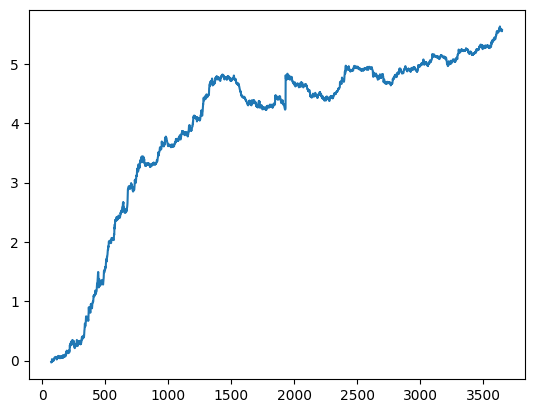

In [66]:
longshort_rets = quantile_longshort_returns(y, y_pred, w, quantile=35, fee_rate=0.001)
display(longshort_rets)
longshort_rets.cumsum().plot()


In [73]:
sharpe_fine(longshort_rets.dropna(), comp=True, annual_bars=_annual_bar_8h)

4.5757979704875975

### old vs New

In [65]:
%timeit _, _ = quantile_returns_and_groups_old(y, y_pred, 35)

%timeit _, _ = quantile_returns_and_groups_new_1(y, y_pred, 35)

978 ms ± 2.71 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


NameError: name 'quantile_returns_and_groups_new_1' is not defined

In [ ]:
%timeit quantile_longshort_returns_old(y, y_pred, w, quantile=35, fee_rate=_fee_rate)
%timeit quantile_longshort_returns_new(y, y_pred, w, quantile=35, fee_rate=_fee_rate)

874 ms ± 89.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
297 ms ± 48.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
a = np.array([1, 2, 1, np.nan, 2])
a == 1

array([ True, False,  True, False, False])